MAE (KNN): 25.27
RMSE (KNN): 35.42


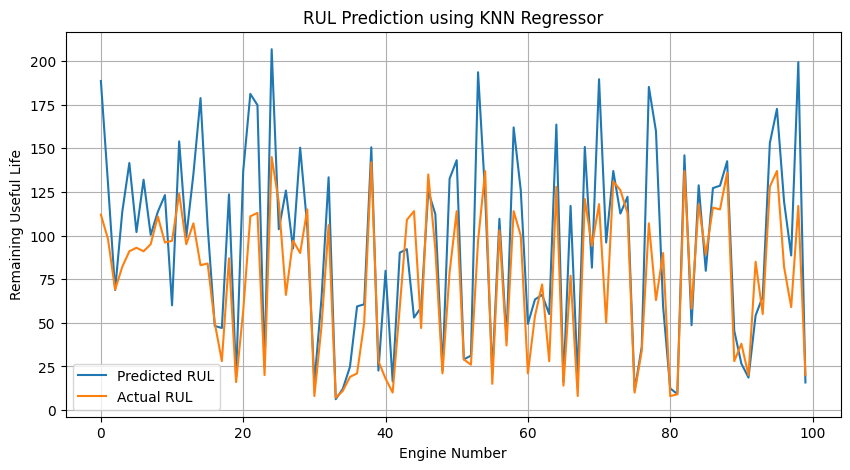

In [1]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# ----------------------------
# STEP 1: Load and preprocess data
# ----------------------------
train = pd.read_csv('./data/train_FD001.txt', sep=' ', header=None)
test = pd.read_csv('./data/test_FD001.txt', sep=' ', header=None)
rul = pd.read_csv('./data/RUL_FD001.txt', sep=' ', header=None)

# Remove space-padded extra columns
train.drop(train.columns[[26, 27]], axis=1, inplace=True)
test.drop(test.columns[[26, 27]], axis=1, inplace=True)

# Assign column names
cols = ['unit', 'time'] + [f'op{i}' for i in range(1, 4)] + [f'sensor{i}' for i in range(1, 22)]
train.columns = test.columns = cols

# ----------------------------
# STEP 2: Add RUL to training data
# ----------------------------
rul_train = train.groupby('unit')['time'].max().reset_index()
rul_train.columns = ['unit', 'max_time']
train = train.merge(rul_train, on='unit')
train['RUL'] = train['max_time'] - train['time']
train.drop('max_time', axis=1, inplace=True)

# ----------------------------
# STEP 3: Feature selection
# ----------------------------
drop_cols = ['unit', 'time', 'RUL'] + [f'sensor{i}' for i in [1, 5, 6, 10, 16, 18, 19]]
features = [col for col in train.columns if col not in drop_cols]
X_train = train[features]
y_train = train['RUL']

# ----------------------------
# STEP 4: Normalize features
# ----------------------------
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)

# ----------------------------
# STEP 5: Train KNN Regressor
# ----------------------------
model = KNeighborsRegressor(n_neighbors=5)
model.fit(X_train_scaled, y_train)

# ----------------------------
# STEP 6: Prepare test data
# ----------------------------
X_test = test.groupby('unit').last().reset_index()
X_test = X_test[features]
X_test_scaled = scaler.transform(X_test)

# Predict RUL
predicted_rul = model.predict(X_test_scaled)

# Actual RUL values
actual_rul = rul.copy()
# Read and clean the RUL file properly
actual_rul = pd.read_csv("./data/RUL_FD001.txt", sep=' ', header=None)

# Drop extra/empty columns if any
actual_rul = actual_rul.dropna(axis=1, how='all')  # removes all-NaN columns
actual_rul.columns = ['RUL']  # ✅ Now this will work


# ----------------------------
# STEP 7: Evaluate
# ----------------------------
mae = mean_absolute_error(actual_rul, predicted_rul)
rmse = np.sqrt(mean_squared_error(actual_rul, predicted_rul))

print(f"MAE (KNN): {mae:.2f}")
print(f"RMSE (KNN): {rmse:.2f}")

# ----------------------------
# STEP 8: Plot predictions
# ----------------------------
plt.figure(figsize=(10, 5))
plt.plot(predicted_rul, label='Predicted RUL')
plt.plot(actual_rul.values, label='Actual RUL')
plt.legend()
plt.title("RUL Prediction using KNN Regressor")
plt.xlabel("Engine Number")
plt.ylabel("Remaining Useful Life")
plt.grid(True)
plt.show()